
Бусько Полина  
polina_petrova_02@bk.ru

---

__Предмет__: Теория и Практика Численных Методов  


# Лабораторная работа №2.   

## Решение линейного уравнения конвекции-диффузии с переменными коэффициентами методом конечных элементов

__Due date:__ 2023.11.03 .  
__Date submitted:__ 2023.10.22




## Введение

## Задание.  

Решить численно, методом конечных элементов с линейными базисными функциями, уравнение конвекции-диффузии с переменными коэффициентами:

$$ 
-\frac{d}{dx}\left( p(x) \frac{du}{dx} \right) + q(x) \cdot \frac{du}{dx} + r(x) \cdot u = f(x), 
\qquad
x \in (0, \pi).
$$

Коэффициенты и источниковый член уравнения имеют вид:

$$
  p(x) = (1+x)^2, \quad  q(x) = 2+x-x^2,  \quad r(x) = \frac{2x - 1}{4}, \quad  
  f(x) = (1+x)^2 + \frac{2x - 1}{4}.
$$

Найдите приближенное решение для случая граничных условий ниже:

$$
\begin{align}
u(x=0) & = 0 \\
p(x) \frac{du}{dx} {\Large\rvert_{x=\pi}} & = 0
\end{align}
$$

Общее решение уравнения:

$$
u(x) = \sqrt{1+x} \left( K_1 + K_2 e^{-x} \right) + \sin(x).
$$

Для заданных граничных условий, выражения для постоянных $K_1$ и $K_2$ принимают вид:
$$
 K_1 =  2 \frac{\sqrt{1 + \pi}} { (1 + e^{-\pi}  (1 + 2\pi))}, \quad 
 K_2 = -2 \frac{\sqrt{1 + \pi}} { (1 + e^{-\pi}  (1 + 2\pi))}
$$

1. (1 балл) Проверить справедливость предложенного точного решения прямой подстановкой в уравнение. При необходимости, воспользоваться возможностями модуля `sympy` для символьных вычислений. 
2. (2 балла) Кратко пояснить схему применения МКЭ для данной задачи для случая линейных базисных функций и неравномерной сетки. Привести в отчете необходимые расчетные формулы для заполнения матрицы жесткости и вектора правых частей. 
3. (4 балла) Реализовать программно алгоритм решения задачи и провести необходимое тестирование.
    
   * Использовать численное интегрирование (Гауссовы квадратуры) для вычисления интегралов при получении коэффициентов локальной матрицы и вектора правых частей на каждом элементе.
   * Предусмотреть случай неравномерных расчетных сеток
   * Предусмотреть возможность быстрой замены типов граничных условий на обоих концах расчетной области

4. (3 балла) Включить в список возможных граничных условий условия 3го рода, вида $$ \left( p(x) \frac{du}{dx} + \alpha_b u \right) {\Large \rvert_{x=b} } = \eta_b$$ Использовать это условие вместо исходного условия 2го рода и исследовать влияние величины коэффициента $\alpha_b$ на решение. Предложить физическую интерпретацию.
   
6. (1 балла) Провести численные эксперименты для проверки сеточной сходимости решения к точному решению. Проверить выполнение теоретической оценки для зависимости $L_2$-нормы погрешности от размера элемента:
   $$
   {\lVert E \rVert}_{L_2} = \sqrt{  \sum_{k=0}^{N-1} \int_{x_k}^{x_{k+1}} \left( U(x) - u(x) \right)^2 dx  }  = С \cdot h^2
   $$
7. (1 балл) Провести численные эксперименты для исследования поведения приближенного решения в случае использования неравномерных сеток. 
   
   

### Решение
#### Задание 1



In [9]:
from sympy import simplify
import math

In [90]:
x = Symbol('x')
pi = Symbol ('pi')
e = Symbol ('e')

k1 = Symbol('k1')
k2 = Symbol('k2')

p = (1 + x) * (1 + x)
q = 2 + x - x * x
r = (2 * x - 1) / 4
f = (1 + x) * (1 + x) + (2 * x - 1) / 4
K1 = 2*((sqrt(1+pi))/(1+e**(-pi)*(1+2*pi)))
K2 = -K1

u = sqrt(1 + x) * K1 * (1 - e**(-x))+sin(x)
du = u.diff(x)
pdu = p * du
dpdu = pdu.diff(x)

simplify(-dpdu + q * du + r * u)


#### Задание 2

$$-\frac{d}{dx}\left( p(x) \frac{du}{dx} \right) + q(x) \cdot \frac{du}{dx} + r(x) \cdot u = f(x), 
\qquad
x \in (0, \pi).$$

Граничные условия: 
$$
\begin{align}
u(x=0) & = 0 \\
p(x) \frac{du}{dx} {\Large\rvert_{x=\pi}} & = 0
\end{align}
$$

Тогда полная постановка задачи имеет вид:

\begin{cases}
-\frac{d}{dx}\left( p(x) \frac{du}{dx} \right) + q(x) \cdot \frac{du}{dx} + r(x) \cdot u = f(x)\\
u(x=0)  = 0 \\
p(x) \frac{du}{dx} {\Large\rvert_{x=\pi}}  = 0
\end{cases}

Введем функцию $v(x): $
функция $v(x)$ интегрируема с квадратом, если существует $\displaystyle\int\limits_{a}^{b}(v(x))^2{dx};\quad v(x) \in L_2$

Введем понятия некоторые пространств:

Пространство $H^1([a,b]) = {v(x)\in L_2 : \displaystyle\int\limits_{a}^{b}(v'(x))^2}dx\quad$ существует и конечен

Пространство $H^1_E = {v(x) \in H^1 : v(x=a) = 0}$

Пространство $H^1_0 = {v \in H^1 : v(x=a) = 0}$

Домножим наше уравнение на на функцию $v$ из пространства $H^1_0$ и поинтегрируем по заданному отрезку

$$
\displaystyle\int\limits_{0}^{\pi}\bigg(-\frac{d}{dx}\left( p(x) \frac{du}{dx} \right) + q(x) \cdot \frac{du}{dx} + r(x) \cdot u\bigg) \cdot v(x)dx = \displaystyle\int\limits_{0}^{\pi}f(x) \cdot v(x) \quad \forall v \in H^1_0[0,\pi] 
$$

Проинтегрировав правую часть равенства по частям, получим:

$$
\big(-p(x) \cdot \frac{du}{dx} \cdot v \big)\bigg|_{0}^{\pi} + \displaystyle\int\limits_{0}^{\pi}\big(p(x)\frac{du}{dx}\frac{dv}{dx} + q(x)\frac{du}{dx}v + r(x)\cdot u\cdot v\big)dx = \displaystyle\int\limits_{0}^{\pi}f(x) \cdot vdx \quad \forall v \in H^1_0[0,\pi]
$$

$$
\big(-p(x) \cdot \frac{du}{dx} \cdot v \big)\bigg|_{0}^{\pi} = \big(-p(x) \cdot \frac{du}{dx} \cdot v \big)\bigg|_{\pi} - \big(-p(x) \cdot \frac{du}{dx} \cdot v \big)\bigg|_{0}
$$

$\big(-p(x) \cdot \frac{du}{dx} \cdot v \big)\bigg|_{\pi} = 0\quad$по условию

$\big(-p(x) \cdot \frac{du}{dx} \cdot v \big)\bigg|_{0} = 0\quad$так как $\quad v(0) = 0$

Тогда получаем: 

$$\displaystyle\int\limits_{0}^{\pi}\big(p(x)\frac{du}{dx}\frac{dv}{dx} + q(x)\frac{du}{dx}v + r(x)\cdot u\cdot v\big)dx = \displaystyle\int\limits_{0}^{\pi}f(x) \cdot v(x)dx$$

Это ослабленная постановка исходной задачи.

Возьмем неравномерную сетку:

![рисунок 1](pictures_lab_2/pic_2_1.png)

$x_0 = 0, \quad x_N = \pi, \quad x_{k+1}>x_k$

Линейная комбинация этих функций будет давать решение.

Базисные функции $\{\varphi_i(x)\}$

$$
\varphi_j(x) = 
\begin{cases}
   \frac{x_{j+1} - x}{x_{j+1} - x_j},\quad x \in [x_j, x_{j+1}]\\
   \frac{x - x_{j-1}}{x_j - x_{j-1}},\quad x \in [x_{j-1}, x_j]\\
\end{cases}
$$

Будет удобно ввести эти фцнкции по-другому. Определим их как отображение на эталонную базисную функцию

![рисунок 2](pictures_lab_2/pic_2_2.png)

Тогда:

$$x=x_k+(x_{k+1}-x_k)\cdot X$$

$$
\begin{cases}
  \varphi_k(x) = \varphi_{loc,1}\big(\frac{x-x_k}{x_{k+1}-x_k}\big) = \frac{x_{k+1}-x}{x_{k+1}-x_k}\\
  \varphi_{k+1}(x) = \varphi_{loc,2}\big(\frac{x-x_k}{x_{k+1}-x_k}\big) = \frac{x-x_k}{x_{k+1}-x_k}\\
  \varphi_j = 0,\quad j \neq k, \quad j \neq k+1
\end{cases}
$$

В качестве тестовых функций будем подставлять функции из базиса по очереди

$$
\sum_{j=0}^Nu_j\displaystyle\int\limits_{0}^{\pi}\bigg(p(x)\cdot\frac{d\varphi_j}{dx}\cdot\frac{d\varphi_i}{dx}+q(x)\cdot\frac{d\varphi_j}{dx}\varphi_i+r(x)\varphi_i\varphi_j\bigg)dx=\displaystyle\int\limits_{0}^{\pi}f(x)\varphi_idx
$$
$$
\displaystyle\int\limits_{0}^{\pi}\bigg(p(x)\cdot\frac{d\varphi_j}{dx}\cdot\frac{d\varphi_i}{dx}+q(x)\cdot\frac{d\varphi_j}{dx}\varphi_i+r(x)\varphi_i\varphi_j\bigg)dx = A_{i,j}
$$
$$
\displaystyle\int\limits_{0}^{\pi}f(x)\varphi_idx = b_i
$$
Так как мы перешли к эталонным базисным функциям ($0<X<1$), то координаты примут следующий вид:
$$
h = x_{k+1} - x_k, \quad k=1,..N\\
x=x_k+hX = \xi, \quad 0<X<1
$$
Тогда 
$$
A_{loc i,j}^{(k)} = h\cdot\displaystyle\int\limits_{0}^{1}\bigg(p\frac{\xi}{h^2}\cdot \frac{\varphi_{loc j}(X)}{dX}\cdot \frac{\varphi_{loc i}(X)}{dX}+\frac{q(\xi)}{h}\frac{\varphi_{loc j}(X)}{dX}\varphi_{loc i}(X)+r(xi)\varphi_{loc i}\cdot\varphi_{loc j}\bigg)dX, \quad i,j = 1,2\\
b_{loc i}^{(k)} = h\cdot\displaystyle\int\limits_{0}^{1}f(\xi)\cdot\varphi_{loc i}(X)dX, \quad i=1,2
$$

Для вычисления этих интегралов будем применять квадратуры Гаусса. Это будет удобно, так как функции $p(x),\quad q(x), \quad r(x)$ заданы полиномами. Интеграл от полинома степени $2M+1$ вычисляется точно. ($M$ - количество точек вычисления)

Запишем эти интегралы в квадратурах:

$$
A_{loc i,j}^{(k)} = h\cdot\sum_{m=0}^{M-1}\bigg(p\frac{x_k+hX_m}{h^2}\frac{d\varphi_{loc i}^{(k)}}{dX}\big|_{X=X_m}\frac{d\varphi_{loc j}^{(k)}}{dX}\big|_{X=X_m}+\frac{q(x_k+hX_m)\cdot \varphi_{loc i}^{(k)}(X_M)\cdot\frac{d\varphi_{loc j}^{(k)}}{dX}\big|_{X=X_M}}{h}+r(x_k+hX_m)\cdot\varphi_{loc i}^{(k)}(X_m)\cdot\varphi_{loc j}^{(k)}(X_m)\bigg)\cdot W_m\\
b_{loc i,j}^{(k)} = h\cdot\sum_{m=0}^{M-1}f(x_k+hX_m)\cdot\varphi_{loc i}^{(k)}(X_m)\cdot W_m
$$
Где $W_m$ - весовой коэффициент, а $X_m$ - гауссовы точки.


#### Задание 3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
def defineFuncP(x):
    p = (1 + x) * (1 + x)
    return p
def defineFuncQ(x):
    q = 2 + x - x * x
    return q
def defineFuncR(x):
    r = (2 * x - 1) / 4
    return r
def defineFuncF(x):
    f = (1 + x) * (1 + x) + (2 * x - 1) / 4
    return f

In [4]:
def functionSolv(N, start, end):
    
    A = np.zeros((N+1,N+1))
    b = np.zeros(N+1)

    x = np.linspace(0, 1, N + 1)
    x = np.sqrt(x)
    x = start + (end - start) * x
    

    M = 3
    GaussQWeight = [5/18, 4/9, 5/18]
    GaussQPoint = [1/2 * (1 - math.sqrt(3/5)), 1/2, 1/2 * (1 + math.sqrt(3/5))];
    
    for k in range(N):
        h = x[k + 1] - x[k]
        A_loc = np.zeros((2, 2))
        b_loc = np.zeros(2)
        
        # Цикл по квадратуре Гаусса
        for m in range (M):
            X = GaussQPoint[m]
            phi_loc = [1 - X, X]
            phi_locPr = [-1, 1]
            
            valueP = defineFuncP(x[k] + h * X)
            valueQ = defineFuncQ(x[k] + h * X)
            valueR = defineFuncR(x[k] + h * X)
            valueF = defineFuncF(x[k] + h * X)
            
            for i in range (2):
                for j in range (2):
                    A_loc[i][j] = A_loc[i][j] + h * GaussQWeight[m] * ((valueP) / (h * h) * phi_locPr[i] * phi_locPr[j] +
                    valueQ / h * phi_loc[i] * phi_locPr[j] + valueR * phi_loc[i] * phi_loc[j])
                b_loc[i] = b_loc[i] + h* GaussQWeight[m] * valueF * phi_loc[i]
        
        A[k:k+1+1,k:k+1+1] += A_loc
        b[k:k+1+1] += b_loc

    A[0,:] = 0; A[0,0] = 1; b[0] = 0 
    b[N] = 0
    
    U = np.linalg.solve(A,b)
    
    return U, x
    #print (A)
    #print (b)

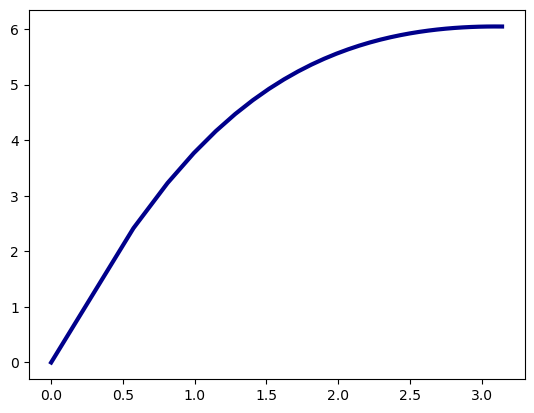

In [5]:
start = 0
end = math.pi
N = 30
U, x = functionSolv(N, start, end)
#print (U)

plt.plot(x, U, linewidth = 3, color = "darkblue")
plt.show()

#### Задание 4

Заменим граничное условие второго рода на правом конце на граничное условие третьего рода, тогда получим следующую формулировку задачи:

$$ 
-\frac{d}{dx}\left( p(x) \frac{du}{dx} \right) + q(x) \cdot \frac{du}{dx} + r(x) \cdot u = f(x), 
\qquad
x \in (0, \pi).
$$

$$
u(x=0) = 0\\
\big(p(x)\cdot\frac{du}{dx} + \alpha u \big)\big |_{x = \pi} = \eta_b 
$$

Умножим данное уравнение на тестовую функцию $v(x) \in H_0^1$ и проинтегрируем по заданному интервалу: $(0, \pi)$

$$
\displaystyle\int\limits_{0}^{\pi}\bigg(-\frac{d}{dx}\left( p(x) \frac{du}{dx} \right) + q(x) \cdot \frac{du}{dx} + r(x) \cdot u\bigg) \cdot v(x)dx = \displaystyle\int\limits_{0}^{\pi}f(x) \cdot v(x) \quad \forall v \in H^1_0[0,\pi] 
$$

Проинтегрировав правую часть равенства по частям, получим:

$$
\big(-p(x) \cdot \frac{du}{dx} \cdot v \big)\bigg|_{0}^{\pi} + \displaystyle\int\limits_{0}^{\pi}\big(p(x)\frac{du}{dx}\frac{dv}{dx} + q(x)\frac{du}{dx}v + r(x)\cdot u\cdot v\big)dx = \displaystyle\int\limits_{0}^{\pi}f(x) \cdot vdx \quad \forall v \in H^1_0[0,\pi]
$$

Так как теперь у нас задано граничное условие третьего рода, а $v(0)= 0$, то данное выражение можно представить в виде:

$$
\displaystyle\int\limits_{0}^{\pi}p(x)\frac{du}{dx}\frac{dv}{dx} + q(x)\frac{du}{dx}v + r(x)uvdx + \alpha u(\pi) v(\pi)=\displaystyle\int\limits_{0}^{\pi}f(x) \cdot vdx+\eta_bv(\pi)
$$

Аналогично тому, как мы делали в случае граничного условия второго рода, в качестве тестовой функции подставляем по очереди функции из базиса:

$$
\displaystyle\int\limits_{0}^{\pi}p(x)\frac{du}{dx}\frac{d\varphi_i}{dx} + q(x)\frac{du}{dx}\varphi_i + r(x)u\varphi_idx + \alpha u(\pi) \varphi_i(\pi)=\displaystyle\int\limits_{0}^{\pi}f(x) \cdot \varphi_idx+\eta_b\varphi_i(\pi)
$$

Видим, что в левой части уравнения появилость дополнительное слагаемое: $\alpha u(\pi) \varphi_i(\pi)$

Как мы уже знаем:
$$
\varphi_i(x_j) = 
\begin{cases}
   1, \quad i = j\\
   0, \quad i\ne j\\
\end{cases}
$$

Поэтому:
$$
\varphi_i(\pi) = 
\begin{cases}
   1, \quad i = N + 1\\
   0, \quad i\ne N + 1\\
\end{cases}
$$

То есть, данное слагаемое даст свой вклад только для последеней сторчки матрицы, а именно для элемента матрицы $A_{N,N}$

$$
A_{N,N} = \displaystyle\int\limits_{0}^{\pi}\bigg(p(x)\cdot\frac{d\varphi_j}{dx}\cdot\frac{d\varphi_i}{dx}+q(x)\cdot\frac{d\varphi_j}{dx}\varphi_i+r(x)\varphi_i\varphi_j\bigg)dx+\alpha
$$


Граничные условия третьего рода задают связь между искомой функцией и её нормальной производной на границе области, то есть связь между неизвестными зараенее темпереатурой и градиентом температуры на границе.
Коэффициент $\alpha$ называется коэффициентом теплоотдачи и является мерой интенсивности конвективного теплообмена
между поверхностью и теплоносителем. Если сделать значение этого коэффициента очень мальньким, то можно говорить, что мы получили частный случай усливия Неймана (граничное условие второго рода) при нулевом тепловом потоке на поверхности.

#### Задание 5

In [6]:
def defineFuncU(x):
    k1 = 2 * (math.sqrt(1 + math.pi)) / (1 + math.e**(-math.pi)*(1 + 2 * math.pi))
    k2 = -k1
    u = math.sqrt(1 + x) * (k1 + k2 * math.e**(-x)) + np.sin(x)
    return u

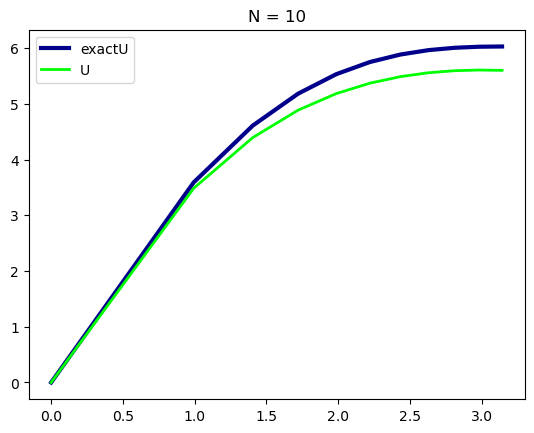

In [7]:
N = 10
U, x = functionSolv(N, start, end)
exactU = np.zeros(N + 1)
for i in range (N + 1):
    exactU[i] = defineFuncU(x[i])
plt.plot(x, exactU, linewidth = 3, color = "darkblue")
plt.plot(x, U, linewidth = 2, color = "lime")
plt.title("N = 10")
plt.legend (('exactU', 'U'))
plt.show()

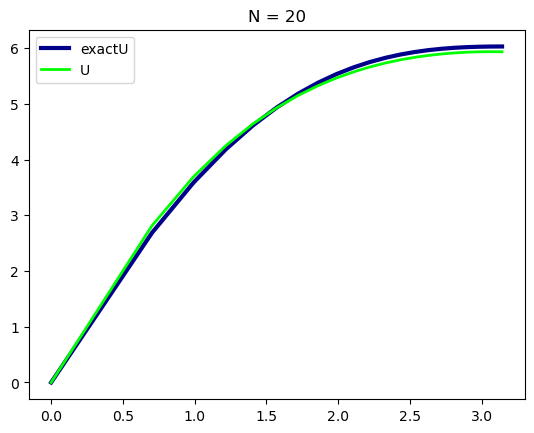

In [8]:
N = 20
U, x = functionSolv(N, start, end)
exactU = np.zeros(N + 1)
for i in range (N + 1):
    exactU[i] = defineFuncU(x[i])
plt.plot(x, exactU, linewidth = 3, color = "darkblue")
plt.plot(x, U, linewidth = 2, color = "lime")
plt.title("N = 20")
plt.legend (('exactU', 'U'))
plt.show()

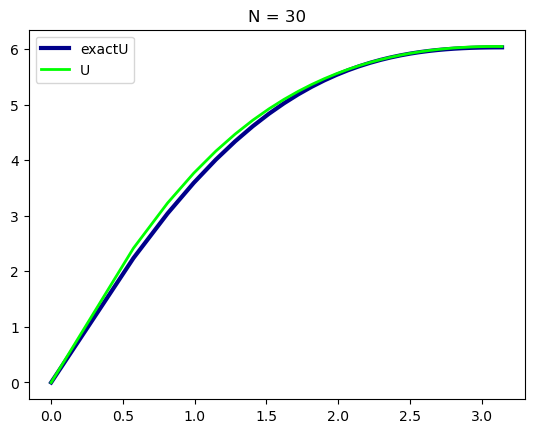

In [9]:
N = 30
U, x = functionSolv(N, start, end)
exactU = np.zeros(N + 1)
for i in range (N + 1):
    exactU[i] = defineFuncU(x[i])
plt.plot(x, exactU, linewidth = 3, color = "darkblue")
plt.plot(x, U, linewidth = 2, color = "lime")
plt.title("N = 30")
plt.legend (('exactU', 'U'))
plt.show()

Из представлнных выше графиков видно, что при увеличении $N$ решение, наденное численно стремится к точному решению.

In [35]:
def functionSolvX(N, start, end, x):
    
    A = np.zeros((N+1,N+1))
    b = np.zeros(N+1)

    M = 3
    GaussQWeight = [5/18, 4/9, 5/18]
    GaussQPoint = [1/2 * (1 - math.sqrt(3/5)), 1/2, 1/2 * (1 + math.sqrt(3/5))];
    
    for k in range(N):
        h = x[k + 1] - x[k]
        A_loc = np.zeros((2, 2))
        b_loc = np.zeros(2)
        
        # Цикл по квадратуре Гаусса
        for m in range (M):
            X = GaussQPoint[m]
            phi_loc = [1 - X, X]
            phi_locPr = [-1, 1]
            
            valueP = defineFuncP(x[k] + h * X)
            valueQ = defineFuncQ(x[k] + h * X)
            valueR = defineFuncR(x[k] + h * X)
            valueF = defineFuncF(x[k] + h * X)
            
            for i in range (2):
                for j in range (2):
                    A_loc[i][j] = A_loc[i][j] + h * GaussQWeight[m] * ((valueP) / (h * h) * phi_locPr[i] * phi_locPr[j] +
                    valueQ / h * phi_loc[i] * phi_locPr[j] + valueR * phi_loc[i] * phi_loc[j])
                b_loc[i] = b_loc[i] + h* GaussQWeight[m] * valueF * phi_loc[i]
        
        A[k:k+1+1,k:k+1+1] += A_loc
        b[k:k+1+1] += b_loc

    A[0,:] = 0; A[0,0] = 1; b[0] = 0 
    b[N] = 0
    
    U = np.linalg.solve(A,b)
    
    return U, x
    #print (A)
    #print (b)

In [41]:
NN = [10, 20, 30, 50]

EE = []
hh = []

for N in NN:
    
    x = np.linspace(0, math.pi, N + 1)
    
    U, x = functionSolvX(N, 0, math.pi, x) # DL
    M = 3
    GaussQWeight = [5/18, 4/9, 5/18]
    GaussQPoint = [1/2 * (1 - math.sqrt(3/5)), 1/2, 1/2 * (1 + math.sqrt(3/5))];
    
    E = 0
    
    for k in range(N):
        h = x[k + 1] - x[k]
        
        # Цикл по квадратуре Гаусса
        for m in range (M):
            X = GaussQPoint[m]
            tmp = (U[k] - defineFuncU(x[k] + h * X)) * (U[k] - defineFuncU(x[k] + h * X))
            E += tmp
            
    E = math.sqrt(E)
    EE.append(E)
    
print (EE)

[3.7398089024913386, 2.022845908252152, 1.1971636246241737, 0.9979882851743049]


#### Задание 6

In [42]:
start = 0
end = math.pi

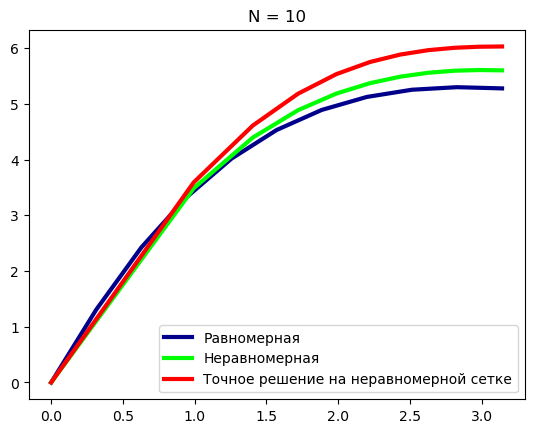

In [43]:
N = 10

# Равномерная сетка
xr = np.linspace(0, math.pi, N + 1)
Ur, xr = functionSolvX(N, start, end, xr)
plt.plot(xr, Ur, linewidth = 3, color = "darkblue")

# Неравномерная сетка
xn = np.linspace(0, 1, N + 1)
xn = np.sqrt(xn)
xn = start + (end - start) * xn
Un, xn = functionSolvX(N, start, end, xn)
plt.plot(xn, Un, linewidth = 3, color = "lime")

exactU = np.zeros(N + 1)
for i in range (N + 1):
    exactU[i] = defineFuncU(xn[i])
plt.plot(xn, exactU, linewidth = 3, color = "red")

plt.title('N = 10')
plt.legend (('Равномерная', 'Неравномерная','Точное решение на неравномерной сетке'))
plt.show()

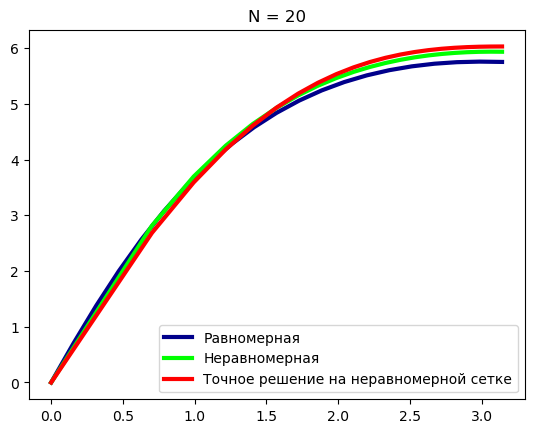

In [44]:
N = 20

# Равномерная сетка
xr = np.linspace(0, math.pi, N + 1)
Ur, xr = functionSolvX(N, start, end, xr)
plt.plot(xr, Ur, linewidth = 3, color = "darkblue")

# Неравномерная сетка
xn = np.linspace(0, 1, N + 1)
xn = np.sqrt(xn)
xn = start + (end - start) * xn
Un, xn = functionSolvX(N, start, end, xn)
plt.plot(xn, Un, linewidth = 3, color = "lime")

exactU = np.zeros(N + 1)
for i in range (N + 1):
    exactU[i] = defineFuncU(xn[i])
plt.plot(xn, exactU, linewidth = 3, color = "red")

plt.title('N = 20')
plt.legend (('Равномерная', 'Неравномерная','Точное решение на неравномерной сетке'))
plt.show()

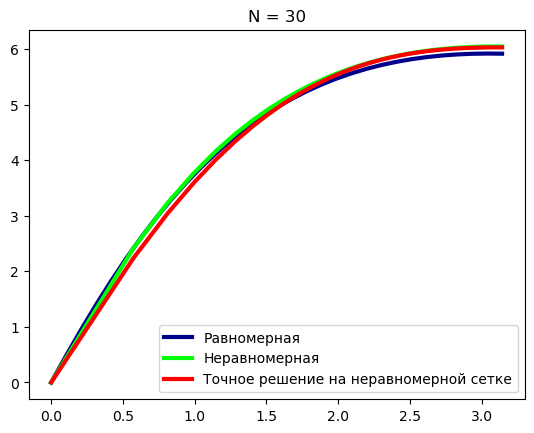

In [45]:
N = 30

# Равномерная сетка
xr = np.linspace(0, math.pi, N + 1)
Ur, xr = functionSolvX(N, start, end, xr)
plt.plot(xr, Ur, linewidth = 3, color = "darkblue")

# Неравномерная сетка
xn = np.linspace(0, 1, N + 1)
xn = np.sqrt(xn)
xn = start + (end - start) * xn
Un, xn = functionSolvX(N, start, end, xn)
plt.plot(xn, Un, linewidth = 3, color = "lime")

exactU = np.zeros(N + 1)
for i in range (N + 1):
    exactU[i] = defineFuncU(xn[i])
plt.plot(xn, exactU, linewidth = 3, color = "red")

plt.title('N = 30')
plt.legend (('Равномерная', 'Неравномерная','Точное решение на неравномерной сетке'))
plt.show()

Из представленных выше графиков видно, что при использовании неравномерной сетки, численное решение ближе к точному

### Выводы

В данной лаборатрной рабтое была проверена формула точного решения уравнения прямой подстановкой в начальное уравнение. Описана схема применения метода конечных элементов для случая линейных базовых функций. Выведены формулы, необходимые для заполнения матрицы жесткости и вектора правых частей. 
Реализован алгоритм решения данной задачи на языке Python. Для вычисления интегралов использовались Гауссовы квадратуры с тремя гауссовыми точками (M = 3). 
Также было рассмотрено граничное условие третьего рода и его влияние (вклад) на решение.
Проведены численные эксперименты для проверки сходимости численного решения к точному. А также исследовано поведение приближенного решения в случае использования неравномерных сеток, приведены соответсвующие графики. 

### Литература

1. Whiteley J. Finite element methods //A Practical Guide. – 2014. – Т. 1.